In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.onnx
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Check GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Unzip data

In [3]:
with zipfile.ZipFile("shamiko.zip") as f:
  f.extractall("data/shamiko")
with zipfile.ZipFile("momo.zip") as f:
  f.extractall("data/momo")

Create and view datasets

In [28]:
all_ds = torchvision.datasets.ImageFolder(
    root='data/',
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
)

classes = all_ds.classes

# Split train test
train_len = int(0.7 * len(all_ds))
train_ds, test_ds = torch.utils.data.random_split(all_ds, (train_len, len(all_ds) - train_len))

train_loader = torch.utils.data.DataLoader(
  train_ds,
  batch_size=4,
  num_workers=4,
  shuffle=True
)
test_loader = torch.utils.data.DataLoader(
  test_ds,
  batch_size=1,
  num_workers=0,
)

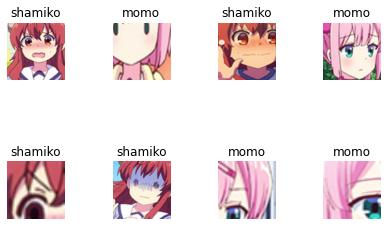

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.tight_layout()
for i, row in enumerate(ax):
  for col in row:
    ds = train_ds if i == 0 else test_ds
    im, class_idx = random.choice(ds)
    col.imshow(im.permute(1, 2, 0))
    col.set_title(classes[class_idx])
    col.axis("off")

Train model

In [30]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Sequential(
      nn.Linear(model.fc.in_features, len(classes)),
      #nn.ReLU(),
      #nn.Linear(256, 10),
      #nn.ReLU(),
      #nn.Linear(10, len(classes)),
      #nn.Softmax(dim=1),
    )
model = model.to(device)

n_epochs = 25

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_f = nn.CrossEntropyLoss()

# Training loop
for i in range(n_epochs):
  running_loss = 0
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_f(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Print metrics
  print(f"Epoch {i+1}:  Loss: {running_loss}")

print("Done!")

Epoch 1:  Loss: 65.40589294582605
Epoch 2:  Loss: 51.198648028075695
Epoch 3:  Loss: 28.5847836881876
Epoch 4:  Loss: 52.05207213759422
Epoch 5:  Loss: 47.014555647969246
Epoch 6:  Loss: 48.11724330484867
Epoch 7:  Loss: 43.00584018975496
Epoch 8:  Loss: 53.15190530568361
Epoch 9:  Loss: 46.24501135200262
Epoch 10:  Loss: 46.00132259726524
Epoch 11:  Loss: 37.286197289824486
Epoch 12:  Loss: 59.29434436559677
Epoch 13:  Loss: 41.22765124589205
Epoch 14:  Loss: 28.3329396545887
Epoch 15:  Loss: 51.151373475790024
Epoch 16:  Loss: 27.66589419543743
Epoch 17:  Loss: 36.15265206992626
Epoch 18:  Loss: 29.478156179189682
Epoch 19:  Loss: 27.21293205022812
Epoch 20:  Loss: 26.272209152579308
Epoch 21:  Loss: 10.522954389452934
Epoch 22:  Loss: 8.55445895344019
Epoch 23:  Loss: 6.591201484203339
Epoch 24:  Loss: 10.058894701302052
Epoch 25:  Loss: 6.603803865611553
Done!


Test Model

In [36]:
label_list = []
predict_list = []

# Test model
model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    label_list.append(labels.item())
    predict_list.append(predicted.item())

# Confusion matrix
conf_mat = confusion_matrix(label_list, predict_list)

print("Confusion Matrix")
print(classes)
print(conf_mat)

class_accuracy = 100*conf_mat.diagonal()/conf_mat.sum(1)
print("Accuracy")
print(class_accuracy)

Confusion Matrix
['momo', 'shamiko']
[[166   0]
 [  3 153]]
Accuracy
[100.          98.07692308]


Export ONNX

In [44]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

model.eval()

torch.onnx.export(
    model,
    dummy_input,
    "final_model.onnx",
    input_names=input_names,
    output_names=output_names,
)